In [3]:
# Instalar bibliotecas necessárias
!pip install tensorflow pandas matplotlib scikit-learn

# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [23]:
# Carregar os dados
from google.colab import files
uploaded = files.upload()  # Faça upload do arquivo CSV

# Ler os dados
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

Saving powerconsumption.csv to powerconsumption (2).csv


In [5]:
# Verificar as primeiras linhas do dataset
print("Primeiras linhas do dataset:")
print(df.head())

Primeiras linhas do dataset:
        Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3    

In [24]:
# Converter para datetime caso ainda não esteja no formato correto
if 'Datetime' in df.columns:
    df['Datetime'] = pd.to_datetime(df['Datetime'])  # Converter a coluna
    df = df.set_index('Datetime')  # Configurar como índice
else:
    df.index = pd.to_datetime(df.index)  # Converter o índice diretamente

# Filtrar para considerar apenas registros às 00, 06, 12 e 18 horas
df = df[(df.index.minute == 0) & (df.index.hour.isin([0, 6, 12, 18]))]

# Verificar as primeiras linhas do dataset
print("Primeiras linhas do dataset:")
print(df.head())

Primeiras linhas do dataset:
                     Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                     
2017-01-01 00:00:00        6.559     73.80      0.083                0.051   
2017-01-01 06:00:00        4.308     77.20      0.081                0.062   
2017-01-01 12:00:00       13.080     54.36      0.077              450.400   
2017-01-01 18:00:00       14.480     63.27      0.080               18.000   
2017-01-02 00:00:00       11.010     75.80      0.076                0.033   

                     DiffuseFlows  PowerConsumption_Zone1  \
Datetime                                                    
2017-01-01 00:00:00         0.119             34055.69620   
2017-01-01 06:00:00         0.126             22219.74684   
2017-01-01 12:00:00        43.200             29644.55696   
2017-01-01 18:00:00        18.290             39560.50633   
2017-01-02 00:00:00         0.163             26703.79747 

In [47]:
# Adicionar colunas para o número do dia da semana
df['day_of_week'] = df.index.weekday  # 0 = Segunda, 6 = Domingo

# Adicionar colunas sin e cos para day_of_year, hour_of_day e day_of_week
df['day_of_year'] = df.index.dayofyear
df['hour_of_day'] = df.index.hour

df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['hour_of_day_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_of_day_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Selecionar as colunas de interesse
target_col = 'PowerConsumption_Zone1'
features = [
    'Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows',
    'day_of_year_sin', 'day_of_year_cos', 'hour_of_day_sin', 'hour_of_day_cos',
    'day_of_week_sin', 'day_of_week_cos', target_col
]

df = df[features].dropna()

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df)

In [42]:
# Verificar as primeiras linhas do dataset
print("Primeiras linhas do dataset:")
print(df.head())

Primeiras linhas do dataset:
                     Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
Datetime                                                                     
2017-01-01 18:00:00        14.48     63.27      0.080               18.000   
2017-01-02 00:00:00        11.01     75.80      0.076                0.033   
2017-01-02 06:00:00         9.58     84.50      0.075                0.048   
2017-01-02 12:00:00        15.21     55.69      0.077              452.500   
2017-01-02 18:00:00        14.54     64.02      0.074               11.040   

                     DiffuseFlows  day_of_year_sin  day_of_year_cos  \
Datetime                                                              
2017-01-01 18:00:00        18.290         0.017213         0.999852   
2017-01-02 00:00:00         0.163         0.034422         0.999407   
2017-01-02 06:00:00         0.134         0.034422         0.999407   
2017-01-02 12:00:00        41.730         0.034422         0.999407  

In [95]:
# Função para criar janelas de tempo
def create_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # Todas as colunas menos a de target
        y.append(data[i + window_size, -1])    # Apenas o target
    return np.array(X), np.array(y)

# Configurar tamanho da janela
window_size = 96  # Janela dos últimos 7 dias para capturar mais contexto
X, y = create_window(data_scaled, window_size)

# Dividir em conjunto de treinamento e teste
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

from tensorflow.keras.layers import GRU


In [96]:
# Definição do modelo GRU (ou LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2



model = Sequential([
    GRU(256, activation='tanh', return_sequences=True, input_shape=(window_size, X.shape[2])),  # Mais neurônios
    Dropout(0.3),  # Maior dropout
    GRU(256, activation='tanh', return_sequences=True),
    Dropout(0.3),
    GRU(256, activation='tanh'),
    Dense(1)
])


# Configuração do otimizador com learning rate scheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0005,  # Taxa de aprendizado inicial
    decay_steps=1000,             # Quantos passos até reduzir
    decay_rate=0.9                # Fator de decaimento
)

from tensorflow.keras.losses import Huber

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=Huber(delta=1.0),  # Huber Loss com delta ajustável
    metrics=['mae']
)

# Resumo do modelo
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Treinar o modelo
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_63 (GRU)                         │ (None, 96, 256)             │         206,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_64 (GRU)                         │ (None, 96, 256)             │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 96, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_65 (GRU)                         │ (None, 256)                 │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 996,353 (3.80 MB)

 Trainable params: 996,353 (3.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 38s 947ms/step - loss: 0.0491 - mae: 0.2526 - val_loss: 0.0312 - val_mae: 0.2228
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 927ms/step - loss: 0.0201 - mae: 0.1621 - val_loss: 0.0205 - val_mae: 0.1801
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 930ms/step - loss: 0.0164 - mae: 0.1437 - val_loss: 0.0110 - val_mae: 0.1333
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 937ms/step - loss: 0.0114 - mae: 0.1214 - val_loss: 0.0074 - val_mae: 0.1068
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 907ms/step - loss: 0.0102 - mae: 0.1129 - val_loss: 0.0054 - val_mae: 0.0910
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 907ms/step - loss: 0.0088 - mae: 0.1047 - val_loss: 0.0059 - val_mae: 0.0945
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 906ms/step - loss: 0.0088 - mae: 0.1035 - val_loss: 0.0050 - val_mae: 0.0849
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 31s 906ms/step - loss: 0.0082 - mae: 0.0988 - val_loss: 0.0062 - val_mae: 0.0925
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step


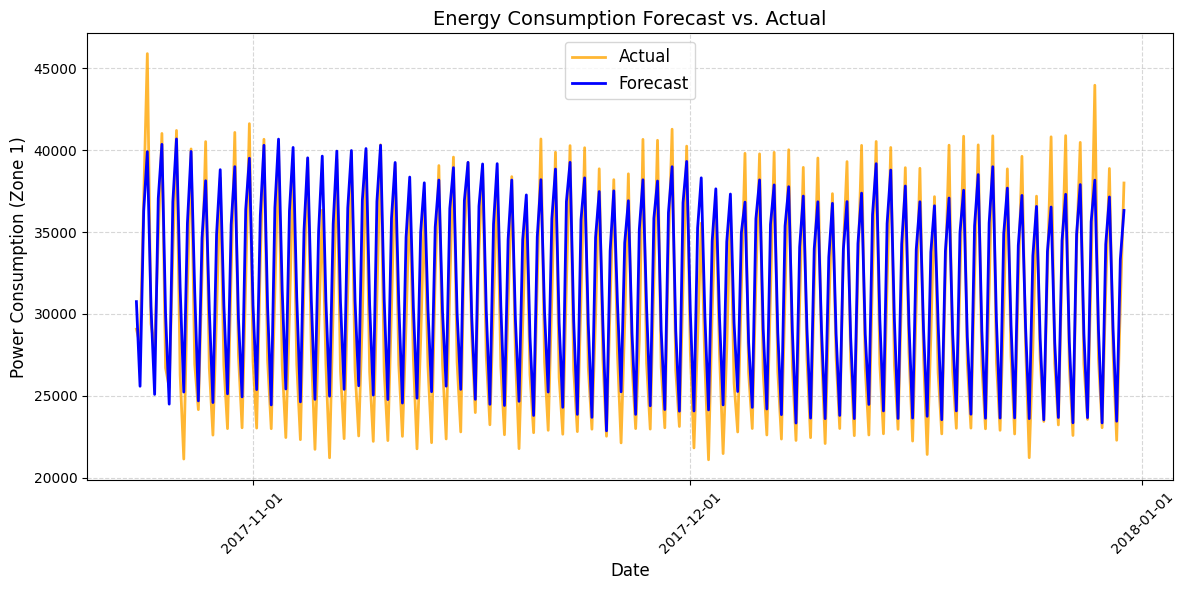

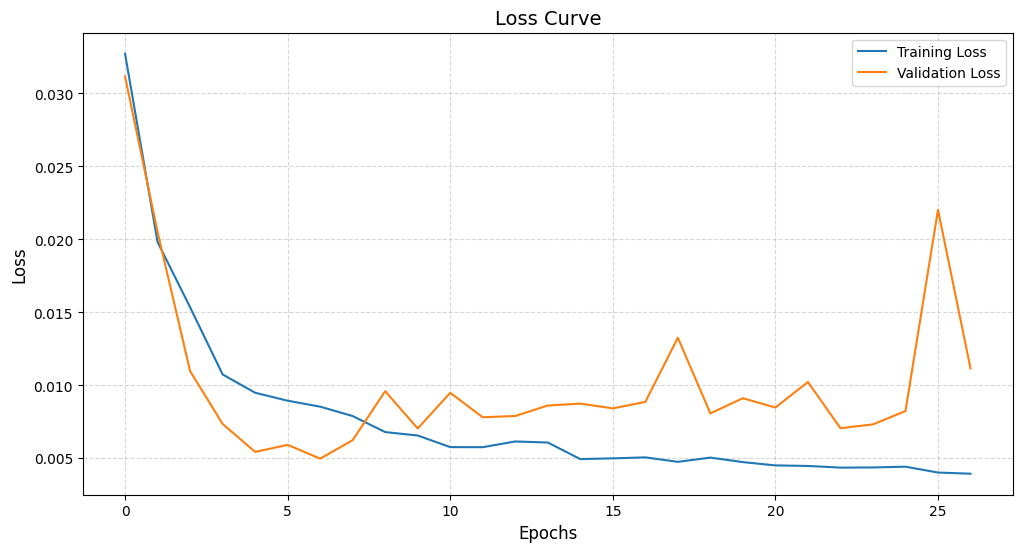

In [97]:
# Fazer previsões
y_pred = model.predict(X_test)

# Reverter a escala apenas para o target
y_test_inverse = scaler.inverse_transform(
    np.hstack((
        np.zeros((len(y_test), data_scaled.shape[1] - 1)),  # Zeros para manter a forma
        y_test.reshape(-1, 1)
    ))
)[:, -1]

y_pred_inverse = scaler.inverse_transform(
    np.hstack((
        np.zeros((len(y_pred), data_scaled.shape[1] - 1)),  # Zeros para manter a forma
        y_pred
    ))
)[:, -1]

# Alternativa mais segura: Aplicar o scaler apenas no target
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(df[[target_col]])
y_test_inverse = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inverse = scaler_target.inverse_transform(y_pred).flatten()

# Gráfico dos resultados
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index[-len(y_test_inverse):], y_test_inverse, label='Actual', color='orange', alpha=0.8, linewidth=2)
ax.plot(df.index[-len(y_pred_inverse):], y_pred_inverse, label='Forecast', color='blue', linewidth=2)

# Ajustar rótulos e título
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Power Consumption (Zone 1)', fontsize=12)
ax.set_title('Energy Consumption Forecast vs. Actual', fontsize=14)

# Configurar o formato do eixo X
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))
plt.xticks(rotation=45)

# Adicionar legenda
ax.legend(fontsize=12)

# Exibir grade
ax.grid(visible=True, linestyle='--', alpha=0.5)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

# Plotar as métricas de treinamento
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Curve', fontsize=14)
plt.legend()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()